# Convert

In [1]:
# Reload the notebook if an external file is updated
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings

from pathlib import Path

path = (
    Path
    .cwd()
    .parent
    .parent
    .joinpath('warbler')
    .as_posix()
)

os.chdir(path)
sys.path.append(path)

warnings.simplefilter(
    'ignore', 
    TqdmExperimentalWarning
)

In [2]:
import json
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import shutil

from avgn.dataset import DataSet
from avgn.signalprocessing.create_spectrogram_dataset import (
    create_label_df,
    get_row_audio,
    log_resize_spec, 
    make_spec, 
    mask_spec,
    pad_spectrogram,
    prepare_wav
)
from avgn.signalprocessing.filtering import prepare_mel_matrix
from avgn.utils.hparams import HParams
from avgn.visualization.spectrogram import draw_spec_set
from constant import AVGN, DATASET, SETTINGS
from datatype.dataset import Dataset
from datatype.settings import Settings
from joblib import Parallel, delayed
from pathlib import Path
from tqdm.autonotebook import tqdm

In [3]:
def create_recording_path(folder, filename):
    return (
        DATASET
        .joinpath(folder)
        .joinpath('recordings')
        .joinpath(filename + '.wav')
    )

In [ ]:
plt.style.use('science')

In [4]:
dataset = Dataset('segment')
original = dataset.load()

drop = [
    'duration',
    'fcm_label_2d',
    'fcm_label_3d',
    'filter_array',
    'filter_bytes',
    'hdbscan_label_2d',
    'hdbscan_label_3d',
    'original',
    'original_array',
    'original_bytes',
    'scale',
    'segment',
    'spectrogram',
    'umap_x_2d',
    'umap_x_3d',
    'umap_y_2d',
    'umap_y_3d',
    'umap_z_3d'
]

original.drop(
    drop, 
    axis=1, 
    errors='ignore', 
    inplace=True
)

columns = {
    'onset': 'start_time',
    'offset': 'end_time',
}

original.rename(
    columns=columns,
    inplace=True
)

original.reset_index(inplace=True)
dataframe = original.copy()

In [5]:
dataframe['wav_loc'] = (
    dataframe.apply(
        lambda x: create_recording_path(
            x['folder'],
            x['filename']
        ),
        axis=1
    )
)

In [6]:
output = AVGN.joinpath('data')
output.mkdir(parents=True, exist_ok=True)

In [7]:
for folder in dataframe.folder.unique():
    individual = dataframe[dataframe.folder == folder]
    
    for filename in individual.filename.unique():
        subset = individual[individual.filename == filename]
        
        wav_loc = subset.wav_loc.tolist()[0].as_posix()
        length_s = librosa.get_duration(path=wav_loc)

        template = {}
        
        template['species'] = 'Setophaga adelaidae'
        template['common_name'] = 'Adelaide\'s warbler'
        template['filename'] = filename
        template['wav_loc'] = wav_loc
 
        template['samplerate_hz'] = 44100
        template['length_s'] = length_s
        
        template['indvs'] = {
            folder: {
                'notes': {
                    'start_times': subset.start_time.tolist(),
                    'end_times': subset.end_time.tolist(),
                    'sequence_num': subset.sequence.tolist(),
                }
            }
        }
        
        text = json.dumps(template, indent=4)
        
        wav = output.joinpath('warbler/wav')
        wav.mkdir(parents=True, exist_ok=True)
        
        file = wav.joinpath(filename + '.wav')
        
        if not file.is_file():
            file.touch()
            
        file = wav.joinpath(filename + '.wav')
        
        if not file.is_file():
            file.touch()
            
        shutil.copy(wav_loc, file)
        
        file = wav.joinpath(filename + '.json')
        
        with open(file, 'w') as handle:
            handle.write(text)

In [8]:
path = SETTINGS.joinpath('spectrogram.json')
settings = Settings.from_file(path)

In [9]:
hparams = HParams(
    n_fft=settings.n_fft,
    hop_length_ms=settings.hop_length_ms,
    win_length_ms=settings.win_length_ms,
    ref_level_db=settings.ref_level_db,
    preemphasis=settings.preemphasis,
    min_level_db=settings.min_level_db,
    min_level_db_floor=settings.min_level_db_floor,
    db_delta=settings.db_delta,
    silence_threshold=settings.silence_threshold,
    min_silence_for_spec=settings.min_silence_for_spec,
    max_vocal_for_spec=settings.max_vocal_for_spec,
    min_syllable_length_s=settings.min_syllable_length_s,
    spectral_range=settings.spectral_range,
    num_mel_bins=settings.num_mel_bins,
    mel_lower_edge_hertz=settings.mel_lower_edge_hertz,
    mel_upper_edge_hertz=settings.mel_upper_edge_hertz,
    butter_lowcut=settings.butter_lowcut,
    butter_highcut=settings.butter_highcut
)

In [10]:
path = output.joinpath('warbler')
dataset = DataSet(path, build_mel_matrix=True, hparams=hparams)

loading json:   0%|          | 0/612 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 612 out of 612 | elapsed:    7.0s finished


getting unique individuals:   0%|          | 0/612 [00:00<?, ?it/s]

In [11]:
n_jobs = -1
verbosity = 0

In [12]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            dict_features_to_retain=['filename'],
            unit='notes',
            key=key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
    
syllable_df = pd.concat(syllable_dfs)

  0%|          | 0/612 [00:00<?, ?it/s]

In [13]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
    
syllable_df = pd.concat(syllable_dfs)

  0%|          | 0/612 [00:00<?, ?it/s]

In [14]:
syllables_wav = syllable_df.audio.tolist()
syllables_rate = syllable_df.rate.tolist()

In [15]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc='Getting syllable spectrograms',
            leave=False,
        )
    )

Getting syllable spectrograms:   0%|          | 0/13192 [00:00<?, ?it/s]

In [16]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    if dataset.hparams.mask_spec:
        syllables_spec = parallel(
            delayed(mask_spec)(syllable, **dataset.hparams.mask_spec_kwargs)
            for syllable in tqdm(
                syllables_spec,
                total=len(syllables_rate),
                desc='Masking spectrograms',
                leave=False,
            )
        )

In [17]:
log_scaling_factor = 10

with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc='Scaling spectrograms', leave=False)
    )

Scaling spectrograms:   0%|          | 0/13192 [00:00<?, ?it/s]

In [18]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

(array([ 745., 2328., 2964., 2361., 1080., 1653., 1201.,  598.,  211.,
          51.]),
 array([32. , 33.8, 35.6, 37.4, 39.2, 41. , 42.8, 44.6, 46.4, 48.2, 50. ]),
 <BarContainer object of 10 artists>)

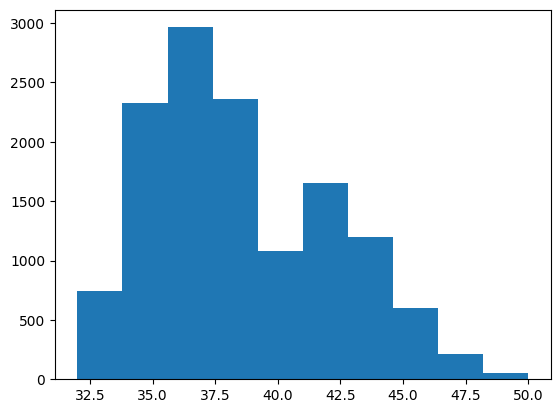

In [19]:
plt.hist(syll_lens)

In [20]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc='Padding spectrograms', leave=False
        )
    )

Padding spectrograms:   0%|          | 0/13192 [00:00<?, ?it/s]

<AxesSubplot: >

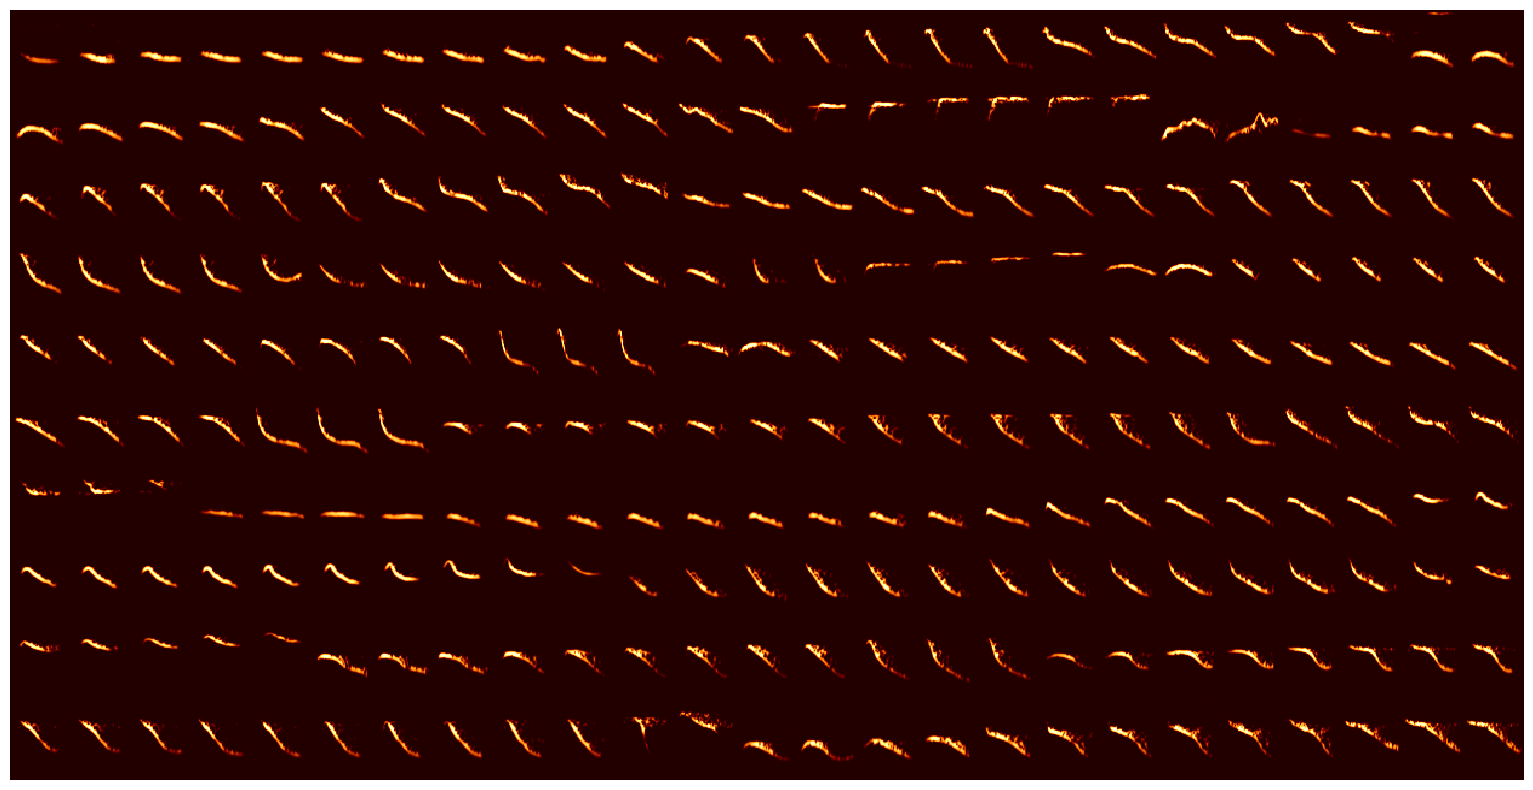

In [21]:
draw_spec_set(
    syllables_spec,
    colsize=25,
    maxrows=10, 
    zoom=1
)

In [22]:
syllable_df['spectrogram'] = syllables_spec
syllable_df['spectrogram'] = syllable_df.spectrogram.apply(lambda x: (x * 255).astype('uint8'))

In [23]:
dataset = Dataset('avgn')
dataset.save(syllable_df)